In [1]:
import sunpy.map
import os, glob
import numpy as np
from pyflct import flct
from matplotlib import pyplot as plt
from matplotlib import colors
from datetime import datetime
from scipy.signal import resample
from aiapy.calibrate import register
import astropy.units as u
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [39]:
def rebin_map_header(oldmap,new_shape,rebinfac=None):
    newmap=sunpy.map.Map(oldmap.data,oldmap.meta)
    if rebinfac is None: rebinfac=newmap.meta['naxis1']/new_shape[0]
    newmap.meta['cdelt1']=newmap.meta['cdelt1']*rebinfac
    newmap.meta['cdelt2']=newmap.meta['cdelt2']*rebinfac
    newmap.meta['naxis1']=new_shape[0]
    newmap.meta['naxis2']=new_shape[1]
    newmap.meta['crpix1']=new_shape[0]/2.
    newmap.meta['crpix2']=new_shape[1]/2.
    newmap.meta['imscl_mp']=newmap.meta['imscl_mp']*rebinfac
    newmap.meta['x0_mp']=newmap.meta['x0_mp']/rebinfac
    newmap.meta['y0_mp']=newmap.meta['y0_mp']/rebinfac
    return newmap


def minmax(arr):
    return np.nanmin(arr),np.nanmax(arr)


def rebin(a, new_shape):
    """
    Resizes a 2d array by averaging or repeating elements, 
    new dimensions must be integral factors of original dimensions
    Parameters
    ----------
    a : array_like
        Input array.
    new_shape : tuple of int
        Shape of the output array
    Returns
    -------
    rebinned_array : ndarray
        If the new shape is smaller of the input array, the data are averaged, 
        if the new shape is bigger array elements are repeated
    See Also
    --------
    resize : Return a new array with the specified shape.
    Examples
    --------
    >>> a = np.array([[0, 1], [2, 3]])
    >>> b = rebin(a, (4, 6)) #upsize
    >>> b
    array([[0, 0, 0, 1, 1, 1],
           [0, 0, 0, 1, 1, 1],
           [2, 2, 2, 3, 3, 3],
           [2, 2, 2, 3, 3, 3]])
    >>> c = rebin(b, (2, 3)) #downsize
    >>> c
    array([[ 0. ,  0.5,  1. ],
           [ 2. ,  2.5,  3. ]])
    """
    M, N = a.shape
    m, n = new_shape
    if m<M:
        return a.reshape((m,M//m,n,N//n)).mean(3).mean(1)
    else:
        return np.repeat(np.repeat(a, m/M, axis=0), n/N, axis=1)
    
    

#Create mp4 movie from png files in a folder, using ffmpeg encoder.
import os, random
import glob
#===============================================================
def png2mp4(datadir,searchfnames,moviefnames,savedir=None,fps=5,force=False):
    #--------------------------USER INPUT--------------------------------
    #
    #fps=5 #FRAMES PER SECOND
    #force=False #Overwrite old files if True
    #datadir='./'
    if savedir is None: savedir=datadir
    #searchfnames=[datadir+'orig_data_t*.png']
    #moviefnames=[savedir+'orig_data.mp4']
    #
    #-----------------------END USER INPUT--------------------------------
    
    process = 'ffmpeg -y -f image2 -r '
    path_call = ' -i '
    ffmpeg_params1 = ' -an -pix_fmt "yuv420p" -vcodec "libx264" -level 41 -crf 18.0 -b "28311k" -r '
    #OLD version
    ffmpeg_params2 = ' -bufsize "28311k" -maxrate "28311k" -g "100" -coder 1 -profile main -preset faster -qdiff 4 -qcomp 0.7 -directpred 3 -flags +loop+mv4 -cmp +chroma -partitions +parti4x4+partp8x8+partb8x8 -subq 7 -me_range 16 -keyint_min 1 -sc_threshold 40 -i_qfactor 0.71 -rc_eq ''blurCplx^(1-qComp)'' -b_strategy 1 -bidir_refine 1 -refs 6 -deblockalpha 0 -deblockbeta 0 -trellis 1 -x264opts keyint=10:min-keyint=1:bframes=1 -threads 2 '
    #NEW version
    ffmpeg_params2 = ' -bufsize "28311k" -maxrate "28311k" -g "100" -coder 1 -profile main -preset faster -qdiff 4 -qcomp 0.7 -direct-pred 3 -flags +loop+mv4 -cmp +chroma -partitions +parti4x4+partp8x8+partb8x8 -subq 7 -me_range 16 -keyint_min 1 -sc_threshold 40 -i_qfactor 0.71 -rc_eq ''blurCplx^\(1-qComp\)'' -b_strategy 1 -bidir_refine 1 -refs 6 -deblock 0:0 -trellis 1 -x264opts keyint=10:min-keyint=1:bframes=1 -threads 2 '

    random.seed()
    err=0
    for ii in range(len(searchfnames)):
        searchfname=datadir+searchfnames[ii]
        moviefname=savedir+moviefnames[ii]
        if os.path.exists(moviefname) and force:
            os.system('rm -f '+moviefname)
        if os.path.isfile(moviefname):
            print('#### File '+moviefname +' already exists.')
            err+=1
            
        #FIND THE PNG FILES
        img_list = glob.glob(searchfname)
        img_list.sort()
        if len(img_list)==0:
            print("#### Found NO image matching the search criterion")
            err+=1
        if len(img_list) < 6:
            print("#### Not enough frames to make movie "+moviefname)
            err+=1
            
        if err == 0:
            randint=random.randint(10000,50000)
            tmpdir=savedir+'tmpdir_'+str(randint)+'/'
            os.system('mkdir -m 0777 '+tmpdir)
            for ii in range(len(img_list)):
                img=img_list[ii]
                iistr=str(ii+1)
                if ii+1 < 10000: iistr='0'+iistr
                if ii+1 < 1000: iistr='0'+iistr
                if ii+1 < 100: iistr='0'+iistr
                if ii+1 < 10: iistr='0'+iistr
                os.system('cp '+img+' '+tmpdir+'tmpim_'+iistr+'.png')
            imgfnames=tmpdir+'tmpim_%05d.png'
            #print(imgfnames)

            command = process + str(fps) + path_call + imgfnames + ffmpeg_params1 + str(fps) + ffmpeg_params2 + moviefname
            print(command)
            os.system(command)
            print(tmpdir)
            os.system('rm -rf '+tmpdir)
    return 1
#===============================================================


def format_string_number(ii):
    #Get a properly formatted index string for saving the output.
    iistr=str(ii)
    #if ii+1 < 10000: iistr='0'+iistr
    if ii+1 < 1000: iistr='0'+iistr
    if ii+1 < 100: iistr='0'+iistr
    if ii+1 < 10: iistr='0'+iistr
    return iistr


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
    
def get_closest_file(datafiles,aiameta):
    #GET THE AIA MASK OBSERVING TIME
    tmp=aiameta['t_obs'].split('T')[1].split(':')
    timstr=tmp[0]+tmp[1]+tmp[2].split('.')[0]
    
    datatimes=[os.path.basename(datafile).split('_')[1] for datafile in datafiles]
    dt=np.array([np.abs(int(datatime)-int(timstr)) for datatime in datatimes])
    
    closeids=np.array(np.where(dt<5))
    if closeids.size == 0:
        dt=[int(datatime)-int(timstr) for datatime in datatimes]
        closestid=np.min(np.where(np.array(dt)>0))
    else:
        closestid=int(closeids[0])
    closest_file=datafiles[closestid]
    #print(closest_file)
    return closest_file,datatimes[closestid]

0094
/data/AIA_data/2011/05/11/H0200/AIA20110511_022026_0094.fits


OSError: File '/HDD/WAVETRACK/RESULTS_VER33/110511/trainset/multiwavelength/masks_applied_orig_data_w_0094_t_022026.fits' already exists.

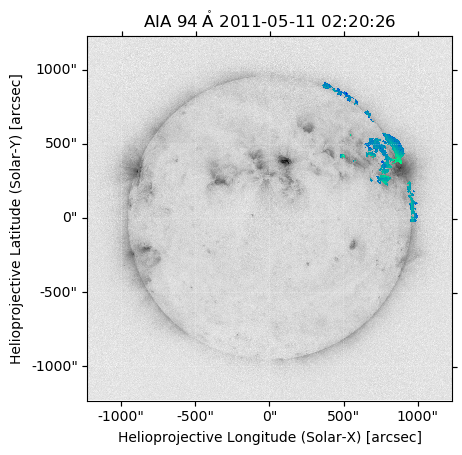

In [42]:
#TEST #1
maskdir='/HDD/WAVETRACK/RESULTS_VER33/110511/trainset/'
datadir='/data/AIA_data/2011/05/11/H0200/'
savedir=maskdir+'multiwavelength/'
searchfnames=['masks_t*.fits']
wavelnth=['0094','0131','0171','0193','0211','0335']

#Get the input mask files
infiles=glob.glob(maskdir+searchfnames[0])
#framepair=['041']
#infile1=[infile for infile in infiles if 't_'+framepair[0] in infile]

for infile in infiles:
    #LOAD THE AIA MASK FILE
    aia1=sunpy.map.Map(infile)
    aia1=rebin_map_header(aia1,[1024,1024],4)
    savesuffix=os.path.basename(infiles[0]).split('masks')[1]
    
    fig = plt.figure(figsize=(16, 12))
    #LOOP OVER THE WAVELENGTHS
    for ww,wav in enumerate(wavelnth):
        print(wav)
        searchdatafnames=['AIA*'+wav+'.fits']
        
        #GET LIST OF AIA DATA, FIND CLOSEST IN TIME FILE
        datafiles=glob.glob(datadir+searchdatafnames[0])
        datafiles.sort()
        closest_file,timestring=get_closest_file(datafiles,aia1.meta)
        print(closest_file)
        
        #LOAD THE ORIGINAL DATA FILE
        aiamaporig=sunpy.map.Map(closest_file)
        aiamap=aiamaporig.resample([1024,1024]*u.pixel)
        aiamap=register(aiamap)
        aiamap=rebin_map_header(aiamap,[1024,1024],4)

        #Create the final map with the applied mask info
        maskmap = sunpy.map.Map(aia1.data * aiamap.data, aiamap.meta)
        maskmap.data[maskmap.data == 0] = np.nan

        ax = fig.add_subplot(231+ww,projection=aia1)
        aiamap.plot(cmap='Greys')
        maskmap.plot(cmap='winter')
        savefile=savedir+'masks_applied_orig_data_w_'+wav+'_t_'+timestring+'.fits'
        if not os.path.isfile(savefile): maskmap.save(savefile)
    plt.tight_layout()
    saveplotfile='masks_applied_orig_data_multiwav'+savesuffix.split('fits')[0]+'png'
    plt.savefig(fname=savedir+saveplotfile)
    plt.show()

2011-05-11T02:24:44.84Z
/data/AIA_data/2011/05/11/H0200/AIA20110511_022450_0094.fits


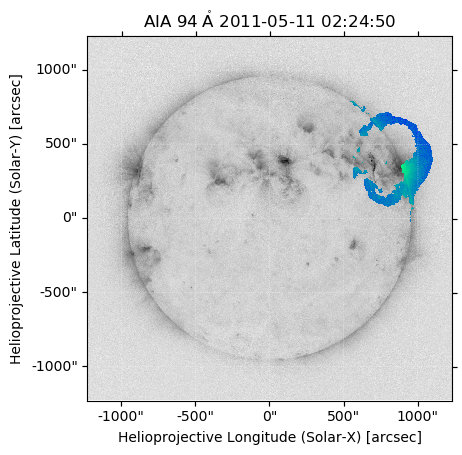

In [38]:
#LOAD THE AIA MASK FILE
infiles=glob.glob(maskdir+searchfnames[0])
infile=infiles[2]
aia1=sunpy.map.Map(infile)
aia1=rebin_map_header(aia1,[1024,1024],4)
savesuffix=os.path.basename(infiles[0]).split('masks')[1]

fig = plt.figure(figsize=(16, 12))
searchdatafnames=['AIA*'+wav+'.fits']
ww=0
wav='0094'
#GET LIST OF AIA DATA, FIND CLOSEST IN TIME FILE
datafiles=glob.glob(datadir+searchdatafnames[0])
datafiles.sort()
#print(datafiles)
print(aia1.meta['t_obs'])
closest_file,timestring=get_closest_file(datafiles,aia1.meta)
print(closest_file)

#LOAD THE ORIGINAL DATA FILE
aiamaporig=sunpy.map.Map(closest_file)
aiamap=aiamaporig.resample([1024,1024]*u.pixel)
aiamap=register(aiamap)
aiamap=rebin_map_header(aiamap,[1024,1024],4)

#Create the final map with the applied mask info
maskmap = sunpy.map.Map(aia1.data * aiamap.data, aiamap.meta)
maskmap.data[maskmap.data == 0] = np.nan

ax = fig.add_subplot(231+ww,projection=aia1)
aiamap.plot(cmap='Greys')
maskmap.plot(cmap='winter') 
plt.show()

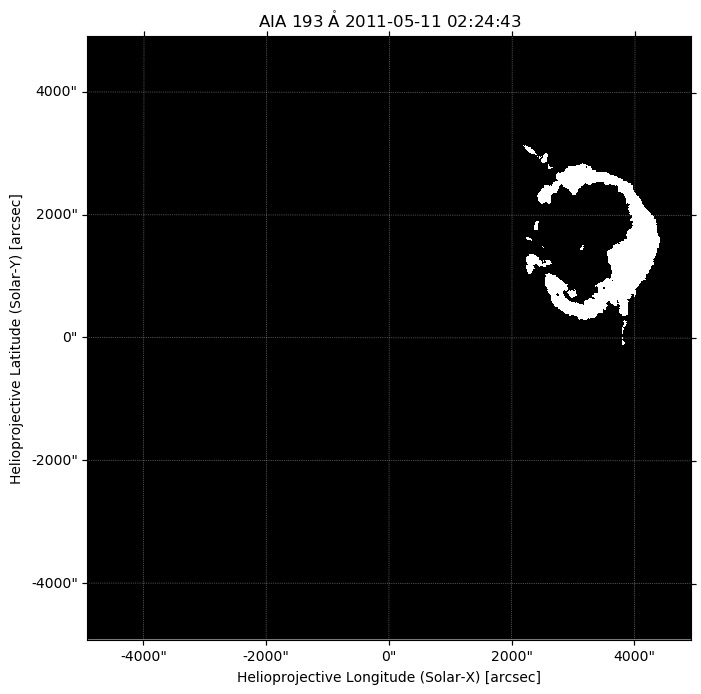

In [552]:
maskdir='/HDD/WAVETRACK/RESULTS_VER33/110511/trainset/'
datadir='/data/AIA_data/2011/05/11/H0200/'
savedir=maskdir+'multiwavelength/'
searchfnames=['masks_t*.fits']
wavelnth=['0094','0131','0171','0193','0211','0335']
wav=wavelnth[0]

#Get the input mask files
infiles=glob.glob(maskdir+searchfnames[0])
savesuffix=os.path.basename(infiles[0]).split('masks')[1]
print((savedir+'masks_applied_orig_data_w_'+wav+savesuffix))
print(savedir+'masks_applied_orig_data_multiwav'+savesuffix.split('fits')[0]+'png')

/HDD/WAVETRACK/RESULTS_VER33/110511/trainset/multiwavelength/masks_applied_orig_data_w_0094_t_011-0_2011-05-11T02:20:19.840.fits
/HDD/WAVETRACK/RESULTS_VER33/110511/trainset/multiwavelength/masks_applied_orig_data_multiwav_t_011-0_2011-05-11T02:20:19.840.png


In [22]:
moviefnames=['masks_applied_orig_data_multiwav.mp4']
searchfname='masks_applied_orig_data_multiwav_t*.png'
png2mp4(indir,[searchfname],moviefnames,savedir=outdir,force=True)

ffmpeg -y -f image2 -r 5 -i /HDD/WAVETRACK/110511_01_take5/trainset/tmpdir_39944/tmpim_%05d.png -an -pix_fmt "yuv420p" -vcodec "libx264" -level 41 -crf 18.0 -b "28311k" -r 5 -bufsize "28311k" -maxrate "28311k" -g "100" -coder 1 -profile main -preset faster -qdiff 4 -qcomp 0.7 -direct-pred 3 -flags +loop+mv4 -cmp +chroma -partitions +parti4x4+partp8x8+partb8x8 -subq 7 -me_range 16 -keyint_min 1 -sc_threshold 40 -i_qfactor 0.71 -rc_eq blurCplx^\(1-qComp\) -b_strategy 1 -bidir_refine 1 -refs 6 -deblock 0:0 -trellis 1 -x264opts keyint=10:min-keyint=1:bframes=1 -threads 2 /HDD/WAVETRACK/110511_01_take5/trainset/masks_on_orig_data.mp4
/HDD/WAVETRACK/110511_01_take5/trainset/tmpdir_39944/


1